# 타이타닉 생존자 예측

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate

## csv 파일 읽어오기

In [22]:
df = pd.read_csv('titanic_dataset/train.csv', encoding='utf-8-sig')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 결측치, 이상치 확인

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 'Age','Cabin','Embarked' 컬럼에 결측치 존재
* 'Age' 결측치는 평균값으로 대체
* 'Cabin' 값은 맨 첫글자만 인덱싱 후 결측치는 'N'으로 대체 
* 'Embarked' 결측치는 최다빈도값으로 대체

In [24]:
df['Cabin'] = df['Cabin'].str[:1]
df['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

In [25]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [26]:
def fillna(df):
    df['Age'].fillna(np.mean(df['Age']), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('S', inplace=True)
    
fillna(df)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## 불필요한 컬럼 drop

In [27]:
df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,N,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,N,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,N,S


## Label encoding을 이용하여 Str 형식의 데이터를 변환
* LabelEncoder을 이용하여 Sex, Cabin, Embarked 컬럼 변환
> 종류 하나마다 숫자부여, 숫자가 크면 가중치가 높아질 수 있음 (선형회귀에 적용x, 트리계열은 괜찮음)

In [57]:
col_list = ['Sex','Cabin','Embarked']

def label_encode(df):
    le = LabelEncoder()    
    for col in col_list:
        df[col] = le.fit_transform(df[col])
    
    return df

encoded_df = df.copy()
label_encode(encoded_df)
encoded_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.000000,1,0,7.2500,7,2
1,1,1,0,38.000000,1,0,71.2833,2,0
2,1,3,0,26.000000,0,0,7.9250,7,2
3,1,1,0,35.000000,1,0,53.1000,2,2
4,0,3,1,35.000000,0,0,8.0500,7,2
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,7,2
887,1,1,0,19.000000,0,0,30.0000,1,2
888,0,3,0,29.699118,1,2,23.4500,7,2
889,1,1,1,26.000000,0,0,30.0000,2,0


### (참고) get_dummies 함수 이용하여 one-hot-encoding
> prefix를 통하여 명확하게 컬럼명을 표시해 줄수있음

In [36]:
df2 = df.copy()
df2 = pd.get_dummies(data=df2, columns=['Sex'], prefix='Sex')
df2 = pd.get_dummies(data=df2, columns=['Cabin'], prefix='Cabin')
df2 = pd.get_dummies(data=df2, columns=['Embarked'], prefix='Embarked')
df2

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,1,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,1
887,1,1,19.000000,0,0,30.0000,1,0,0,1,0,0,0,0,0,0,0,0,0,1
888,0,3,29.699118,1,2,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,1
889,1,1,26.000000,0,0,30.0000,0,1,0,0,1,0,0,0,0,0,0,1,0,0


## 데이터타입을 정수형으로 변환 후 X,y 값 분리

In [61]:
#encoded_df = encoded_df.astype('int64')
X_final = encoded_df.drop('Survived', axis=1)
y_final = encoded_df['Survived']
X_final = X_final.astype('int64')

## train set, test set 분리
> train_test_split 이용

>shape을 써서 train, test set이 제대로 분리됐는지 확인할 수 있음

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final,
                                                   test_size=0.2,
                                                   random_state=10)

## 분류 모델에 데이터를 fit, predict 후 정확도 확인
* classification_report를 이용하여 자세한 평가지표 확인

In [79]:
models = list()
model_knn = KNeighborsClassifier()
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_svm = SVC()

models.append(model_knn)
models.append(model_dt)
models.append(model_rf)
models.append(model_svm)

for model in models:
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, model_pred)
    print(str(model)[:-2], ':', accuracy)
    print(classification_report(y_test, model_pred))

KNeighborsClassifier : 0.7318435754189944
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       117
           1       0.61      0.65      0.62        62

    accuracy                           0.73       179
   macro avg       0.71      0.71      0.71       179
weighted avg       0.74      0.73      0.73       179

DecisionTreeClassifier : 0.8100558659217877
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       117
           1       0.73      0.73      0.73        62

    accuracy                           0.81       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

RandomForestClassifier : 0.8268156424581006
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       117
           1       0.75      0.74      0.75        62

    accuracy                           0.83       17

## 교차 검증 후 정확도 확인

In [72]:
kfold = KFold(n_splits=7, random_state=10)
for model in models:
    score = cross_val_score(model, X_final, y_final, cv=kfold)
    print(str(model)[:-2], '교차검증 평균 :', score.mean())

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


KNeighborsClassifier 교차검증 평균 : 0.6947852221597302
DecisionTreeClassifier 교차검증 평균 : 0.7879552165354331
RandomForestClassifier 교차검증 평균 : 0.8126581833520811
SVC 교차검증 평균 : 0.6745904808773904


## (참고) heatmap 그리기
* heatmap을 그려 각 변수들의 상관관계를 한눈에 확인할 수 있음

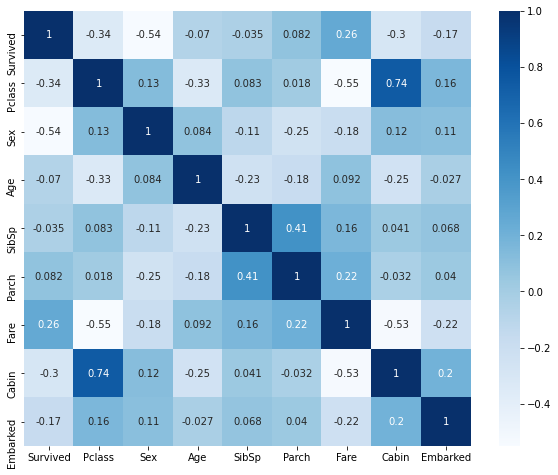

In [92]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(encoded_df.corr(),cmap='Blues', annot=True)

 # -최종-
 #### 1. 데이터 전처리를 함수로 만들기
 #### 2. train, test 데이터에 모두 적용
 #### 3. 가장 높은 성능의 RandomForestClassifier로 kaggle에 submit 할 파일 생성

In [21]:
train_df = pd.read_csv('titanic_dataset/train.csv', encoding='utf-8-sig')
test_df = pd.read_csv('titanic_dataset/test.csv', encoding='utf-8-sig')

def fillna(df):
    df['Cabin'] = df['Cabin'].str[:1]
    df['Cabin'].fillna('N', inplace=True)
    df['Age'].fillna(np.mean(df['Age']), inplace=True)
    df['Embarked'].fillna('S',  inplace=True)
    df['Fare'].fillna(np.mean(df['Fare']), inplace=True)
    
    return df

def dropcol(df):
    df.drop(['Name','Ticket'], axis=1, inplace=True)
    
    return df

def label_encode(df):
    col_list = ['Sex','Cabin','Embarked']
    le = LabelEncoder()
    for col in col_list:
        df[col] = le.fit_transform(df[col])
        
    return df

def cleaning(df):
    fillna(df)
    dropcol(df)
    label_encode(df)
    
    return df

cleaning(train_df)
cleaning(test_df)

X_final = train_df.drop('Survived', axis=1)
y_final = train_df['Survived']
X_final = X_final.astype('int64')


rf_clf = RandomForestClassifier()
kfold = KFold(n_splits=7, shuffle=True, random_state=10)
rf_clf_cv = cross_validate(rf_clf, X_final, y_final, cv=kfold)
print(rf_clf_cv)
rf_clf.fit(X_final, y_final)
test_df['Survived'] = rf_clf.predict(test_df)

submit = test_df[['PassengerId','Survived']]
submit.to_csv('submit.csv', index=False)

submit['Survived'].value_counts()


{'fit_time': array([0.42382264, 0.39755869, 0.4079318 , 0.425565  , 0.45109391,
       0.43488169, 0.50460744]), 'score_time': array([0.02556801, 0.02708364, 0.02987647, 0.03103852, 0.02647638,
       0.02724218, 0.04093432]), 'test_score': array([0.8515625 , 0.828125  , 0.82677165, 0.78740157, 0.7480315 ,
       0.79527559, 0.83464567])}


0    306
1    112
Name: Survived, dtype: int64

## Kaggle score : 0.78947
## Kaggle ranking : 2746